In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
import os
import six
import json
from types import MethodType
import cv2
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
import glob
import itertools
import random
import keras
import keras.backend as K
from keras.models import *
from keras import layers
from keras.layers import *
from keras.utils import plot_model
import graphviz
import pydot
import imgaug as ia
from imgaug import augmenters as iaa

Using TensorFlow backend.


In [4]:
os.chdir(r'/content/drive/My Drive/project')
print(os.getcwd())

dataset_dir = os.path.join('.', 'dataset')
camvid_dir = os.path.join(dataset_dir, 'CamVid')
print(dataset_dir)
print(camvid_dir)

/content/drive/My Drive/project
./dataset
./dataset/CamVid


In [0]:
"""Global settings"""

IMAGE_ORDERING = 'channels_last'

random.seed(0)
class_colors = [(random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in range(5000)]

NumOfClass = 12

In [0]:
"""Augmentation Module"""

seq = [None]


def load_aug():
    sometimes = lambda aug: iaa.Sometimes(0.5, aug)

    seq[0] = iaa.Sequential(
        [
            # apply the following augmenters to most images
            iaa.Fliplr(0.5),  # horizontally flip 50% of all images
            iaa.Flipud(0.2),  # vertically flip 20% of all images
            # crop images by -5% to 10% of their height/width
            sometimes(iaa.CropAndPad(
                percent=(-0.05, 0.1),
                pad_mode=ia.ALL,
                pad_cval=(0, 255)
            )),
            sometimes(iaa.Affine(
                scale={"x": (0.8, 1.2), "y": (0.8, 1.2)},
                # scale images to 80-120% of their size, individually per axis
                translate_percent={"x": (-0.2, 0.2), "y": (-0.2, 0.2)},  # translate by -20 to +20 percent (per axis)
                rotate=(-45, 45),  # rotate by -45 to +45 degrees
                shear=(-16, 16),  # shear by -16 to +16 degrees
                order=[0, 1],  # use nearest neighbour or bilinear interpolation (fast)
                cval=(0, 255),  # if mode is constant, use a cval between 0 and 255
                mode=ia.ALL  # use any of scikit-image's warping modes (see 2nd image from the top for examples)
            )),
            # execute 0 to 5 of the following (less important) augmenters per image
            # don't execute all of them, as that would often be way too strong
            iaa.SomeOf((0, 5),
                       [
                           sometimes(iaa.Superpixels(p_replace=(0, 1.0), n_segments=(20, 200))),
                           # convert images into their superpixel representation
                           iaa.OneOf([
                               iaa.GaussianBlur((0, 3.0)),  # blur images with a sigma between 0 and 3.0
                               iaa.AverageBlur(k=(2, 7)),
                               # blur image using local means with kernel sizes between 2 and 7
                               iaa.MedianBlur(k=(3, 11)),
                               # blur image using local medians with kernel sizes between 2 and 7
                           ]),
                           iaa.Sharpen(alpha=(0, 1.0), lightness=(0.75, 1.5)),  # sharpen images
                           iaa.Emboss(alpha=(0, 1.0), strength=(0, 2.0)),  # emboss images
                           # search either for all edges or for directed edges,
                           # blend the result with the original image using a blobby mask
                           iaa.SimplexNoiseAlpha(iaa.OneOf([
                               iaa.EdgeDetect(alpha=(0.5, 1.0)),
                               iaa.DirectedEdgeDetect(alpha=(0.5, 1.0), direction=(0.0, 1.0)),
                           ])),
                           iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05 * 255), per_channel=0.5),
                           # add gaussian noise to images
                           iaa.OneOf([
                               iaa.Dropout((0.01, 0.1), per_channel=0.5),  # randomly remove up to 10% of the pixels
                               iaa.CoarseDropout((0.03, 0.15), size_percent=(0.02, 0.05), per_channel=0.2),
                           ]),
                           iaa.Invert(0.05, per_channel=True),  # invert color channels
                           iaa.Add((-10, 10), per_channel=0.5),
                           # change brightness of images (by -10 to 10 of original value)
                           iaa.AddToHueAndSaturation((-20, 20)),  # change hue and saturation
                           # either change the brightness of the whole image (sometimes
                           # per channel) or change the brightness of subareas
                           iaa.OneOf([
                               iaa.Multiply((0.5, 1.5), per_channel=0.5),
                               iaa.FrequencyNoiseAlpha(
                                   exponent=(-4, 0),
                                   first=iaa.Multiply((0.5, 1.5), per_channel=True),
                                   second=iaa.ContrastNormalization((0.5, 2.0))
                               )
                           ]),
                           iaa.ContrastNormalization((0.5, 2.0), per_channel=0.5),  # improve or worsen the contrast
                           iaa.Grayscale(alpha=(0.0, 1.0)),
                           sometimes(iaa.ElasticTransformation(alpha=(0.5, 3.5), sigma=0.25)),
                           # move pixels locally around (with random strengths)
                           sometimes(iaa.PiecewiseAffine(scale=(0.01, 0.05))),
                           # sometimes move parts of the image around
                           sometimes(iaa.PerspectiveTransform(scale=(0.01, 0.1)))
                       ],
                       random_order=True
                       )
        ],
        random_order=True
    )


def _augment_seg(img, seg):
    if seq[0] is None:
        load_aug()

    aug_det = seq[0].to_deterministic()
    image_aug = aug_det.augment_image(img)

    segmap = ia.SegmentationMapOnImage(seg, nb_classes=np.max(seg) + 1, shape=img.shape)
    segmap_aug = aug_det.augment_segmentation_maps(segmap)
    segmap_aug = segmap_aug.get_arr_int()

    return image_aug, segmap_aug


def try_n_times(fn, n, *args, **kargs):
    attempts = 0

    while attempts < n:
        try:
            return fn(*args, **kargs)
        except Exception as e:
            attempts += 1

    return fn(*args, **kargs)


def augment_seg(img, seg):
    return try_n_times(_augment_seg, 10, img, seg)

In [0]:
"""DataLoader Module"""


def get_pairs_from_paths(images_path, segs_path):
    images = glob.glob(os.path.join(images_path, "*.jpg")) + glob.glob(os.path.join(images_path, "*.png")) + glob.glob(
        os.path.join(images_path, "*.jpeg"))
    segmentations = glob.glob(os.path.join(segs_path, "*.png"))

    segmentations_d = dict(zip(segmentations, segmentations))

    ret = []

    for im in images:
        seg_bnme = os.path.basename(im).replace(".jpg", ".png").replace(".jpeg", ".png")
        seg = os.path.join(segs_path, seg_bnme)
        assert (seg in segmentations_d), (
                im + " is present in " + images_path + " but " + seg_bnme + " is not found in " + segs_path + " . Make sure annotation image are in .png")
        ret.append((im, seg))

    return ret


def get_image_arr(path, width, height, imgNorm="sub_mean", odering='channels_first'):
    if type(path) is np.ndarray:
        img = path
    else:
        img = cv2.imread(path, 1)

    if imgNorm == "sub_and_divide":
        img = np.float32(cv2.resize(img, (width, height))) / 127.5 - 1
    elif imgNorm == "sub_mean":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img[:, :, 0] -= 103.939
        img[:, :, 1] -= 116.779
        img[:, :, 2] -= 123.68
        img = img[:, :, ::-1]
    elif imgNorm == "divide":
        img = cv2.resize(img, (width, height))
        img = img.astype(np.float32)
        img = img / 255.0

    if odering == 'channels_first':
        img = np.rollaxis(img, 2, 0)
    return img


def get_segmentation_arr(path, nClasses, width, height, no_reshape=False):
    seg_labels = np.zeros((height, width, nClasses))

    if type(path) is np.ndarray:
        img = path
    else:
        img = cv2.imread(path, 1)

    img = cv2.resize(img, (width, height), interpolation=cv2.INTER_NEAREST)
    img = img[:, :, 0]

    for c in range(nClasses):
        seg_labels[:, :, c] = (img == c).astype(int)

    if no_reshape:
        return seg_labels

    seg_labels = np.reshape(seg_labels, (width * height, nClasses))
    return seg_labels


def verify_segmentation_dataset(images_path, segs_path, n_classes):
    img_seg_pairs = get_pairs_from_paths(images_path, segs_path)

    assert len(img_seg_pairs) > 0, "Dataset looks empty or path is wrong "

    for im_fn, seg_fn in tqdm(img_seg_pairs):
        img = cv2.imread(im_fn)
        seg = cv2.imread(seg_fn)

        assert (img.shape[0] == seg.shape[0] and img.shape[1] == seg.shape[
            1]), "The size of image and the annotation does not match or they are corrupt " + im_fn + " " + seg_fn
        assert (np.max(seg[:, :, 0]) < n_classes), "The pixel values of seg image should be from 0 to " + str(
            n_classes - 1) + " . Found pixel value " + str(np.max(seg[:, :, 0]))

    print("Dataset verified! ")


def image_segmentation_generator(images_path, segs_path, batch_size, n_classes, input_height, input_width,
                                 output_height, output_width, do_augment=False):
    img_seg_pairs = get_pairs_from_paths(images_path, segs_path)
    random.shuffle(img_seg_pairs)
    zipped = itertools.cycle(img_seg_pairs)

    while True:
        X = []
        Y = []
        for _ in range(batch_size):
            im, seg = next(zipped)

            im = cv2.imread(im, 1)
            seg = cv2.imread(seg, 1)

            if do_augment:
                im, seg[:, :, 0] = augment_seg(im, seg[:, :, 0])

            X.append(get_image_arr(im, input_width, input_height, odering=IMAGE_ORDERING))
            Y.append(get_segmentation_arr(seg, n_classes, output_width, output_height))

        yield np.array(X), np.array(Y)

In [0]:
"""Metrics module"""


def get_iou(gt, pr, n_classes):
    gt = gt.reshape(pr.shape)
    class_wise = np.zeros(n_classes)
    for cl in range(n_classes):
        intersection = np.sum((gt == cl) * (pr == cl))
        union = np.sum(np.maximum((gt == cl), (pr == cl)))
        iou = float(intersection) / (union + 1e-12)
        class_wise[cl] = iou
    return class_wise

In [0]:
"""Predict Module"""


def model_from_checkpoint_path(checkpoints_path):
    assert (os.path.isfile(checkpoints_path + "_config.json")), "Checkpoint not found."
    model_config = json.loads(open(checkpoints_path + "_config.json", "r").read())
    latest_weights = find_latest_checkpoint(checkpoints_path)
    assert (not latest_weights is None), "Checkpoint not found."
    model = model_from_name[model_config['model_class']](model_config['n_classes'],
                                                         input_height=model_config['input_height'],
                                                         input_width=model_config['input_width'])
    print("loaded weights ", latest_weights)
    model.load_weights(latest_weights)
    return model


def predict(model=None, inp=None, out_fname=None, checkpoints_path=None):
    if model is None and (not checkpoints_path is None):
        model = model_from_checkpoint_path(checkpoints_path)

    assert (not inp is None)
    assert ((type(inp) is np.ndarray) or isinstance(inp,
                                                    six.string_types)), "Inupt should be the CV image or the input file name"

    if isinstance(inp, six.string_types):
        inp = cv2.imread(inp)

    assert len(inp.shape) == 3, "Image should be h,w,3 "
    orininal_h = inp.shape[0]
    orininal_w = inp.shape[1]

    output_width = model.output_width
    output_height = model.output_height
    input_width = model.input_width
    input_height = model.input_height
    n_classes = model.n_classes

    x = get_image_arr(inp, input_width, input_height, odering=IMAGE_ORDERING)
    pr = model.predict(np.array([x]))[0]
    pr = pr.reshape((output_height, output_width, n_classes)).argmax(axis=2)

    seg_img = np.zeros((output_height, output_width, 3))
    colors = class_colors

    for c in range(n_classes):
        seg_img[:, :, 0] += ((pr[:, :] == c) * (colors[c][0])).astype('uint8')
        seg_img[:, :, 1] += ((pr[:, :] == c) * (colors[c][1])).astype('uint8')
        seg_img[:, :, 2] += ((pr[:, :] == c) * (colors[c][2])).astype('uint8')

    seg_img = cv2.resize(seg_img, (orininal_w, orininal_h))

    if not out_fname is None:
        cv2.imwrite(out_fname, seg_img)

    return pr


def predict_multiple(model=None, inps=None, inp_dir=None, out_dir=None, checkpoints_path=None):
    if model is None and (not checkpoints_path is None):
        model = model_from_checkpoint_path(checkpoints_path)

    if inps is None and (not inp_dir is None):
        inps = glob.glob(os.path.join(inp_dir, "*.jpg")) + glob.glob(os.path.join(inp_dir, "*.png")) + glob.glob(
            os.path.join(inp_dir, "*.jpeg"))

    assert type(inps) is list

    all_prs = []

    for i, inp in enumerate(tqdm(inps)):
        if out_dir is None:
            out_fname = None
        else:
            if isinstance(inp, six.string_types):
                out_fname = os.path.join(out_dir, os.path.basename(inp))
            else:
                out_fname = os.path.join(out_dir, str(i) + ".jpg")

        pr = predict(model, inp, out_fname)
        all_prs.append(pr)

    return all_prs


def evaluate(model=None, inp_images=None, annotations=None, checkpoints_path=None):
    # assert False, "not implemented "

    ious = []

    for inp, ann in tqdm(zip(inp_images, annotations)):
        pr = predict(model, inp)
        gt = get_segmentation_arr(ann, model.n_classes, model.output_width, model.output_height)
        gt = gt.argmax(-1)
        iou = get_iou(gt, pr, model.n_classes)
        ious.append(iou)
    ious = np.array(ious)
    print("Class wise IoU ", np.mean(ious, axis=0))
    print("Total  IoU ", np.mean(ious))

In [0]:
"""General model utilities"""


def resize_image(inp, s, data_format):
    try:

        return Lambda(lambda x: K.resize_images(x,
                                                height_factor=s[0],
                                                width_factor=s[1],
                                                data_format=data_format,
                                                interpolation='bilinear'))(inp)

    except Exception as e:

        # if keras is old , then rely on the tf function ... sorry theono/cntk users .
        assert data_format == 'channels_last'
        assert IMAGE_ORDERING == 'channels_last'

        import tensorflow as tf

        return Lambda(
            lambda x: tf.image.resize_images(
                x, (K.int_shape(x)[1] * s[0], K.int_shape(x)[2] * s[1]))
        )(inp)


def get_segmentation_model(input, output):
    img_input = input
    o = output

    o_shape = Model(img_input, o).output_shape
    i_shape = Model(img_input, o).input_shape

    if IMAGE_ORDERING == 'channels_first':
        output_height = o_shape[2]
        output_width = o_shape[3]
        input_height = i_shape[2]
        input_width = i_shape[3]
        n_classes = o_shape[1]
        o = (Reshape((-1, output_height * output_width)))(o)
        o = (Permute((2, 1)))(o)
    elif IMAGE_ORDERING == 'channels_last':
        output_height = o_shape[1]
        output_width = o_shape[2]
        input_height = i_shape[1]
        input_width = i_shape[2]
        n_classes = o_shape[3]
        o = (Reshape((output_height * output_width, -1)))(o)

    o = (Activation('softmax'))(o)
    model = Model(img_input, o)
    model.output_width = output_width
    model.output_height = output_height
    model.n_classes = n_classes
    model.input_height = input_height
    model.input_width = input_width
    model.model_name = ""

    model.train = MethodType(train, model)
    model.predict_segmentation = MethodType(predict, model)
    model.predict_multiple = MethodType(predict_multiple, model)
    model.evaluate_segmentation = MethodType(evaluate, model)

    return model


def vanilla_encoder(input_height=224, input_width=224):
    kernel = 3
    filter_size = 64
    pad = 1
    pool_size = 2

    if IMAGE_ORDERING == 'channels_first':
        img_input = Input(shape=(3, input_height, input_width))
    elif IMAGE_ORDERING == 'channels_last':
        img_input = Input(shape=(input_height, input_width, 3))

    x = img_input
    levels = []

    x = (ZeroPadding2D((pad, pad), data_format=IMAGE_ORDERING))(x)
    x = (Conv2D(filter_size, (kernel, kernel), data_format=IMAGE_ORDERING, padding='valid'))(x)
    x = (BatchNormalization())(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D((pool_size, pool_size), data_format=IMAGE_ORDERING))(x)
    levels.append(x)

    x = (ZeroPadding2D((pad, pad), data_format=IMAGE_ORDERING))(x)
    x = (Conv2D(128, (kernel, kernel), data_format=IMAGE_ORDERING, padding='valid'))(x)
    x = (BatchNormalization())(x)
    x = (Activation('relu'))(x)
    x = (MaxPooling2D((pool_size, pool_size), data_format=IMAGE_ORDERING))(x)
    levels.append(x)

    for _ in range(3):
        x = (ZeroPadding2D((pad, pad), data_format=IMAGE_ORDERING))(x)
        x = (Conv2D(256, (kernel, kernel), data_format=IMAGE_ORDERING, padding='valid'))(x)
        x = (BatchNormalization())(x)
        x = (Activation('relu'))(x)
        x = (MaxPooling2D((pool_size, pool_size), data_format=IMAGE_ORDERING))(x)
        levels.append(x)

    return img_input, levels

In [0]:
"""VGG related"""


def get_vgg_encoder(input_height=224, input_width=224, pretrained='imagenet'):
    if IMAGE_ORDERING == 'channels_first':
        pretrained_url = "https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_th_dim_ordering_th_kernels_notop.h5"
    elif IMAGE_ORDERING == 'channels_last':
        pretrained_url = "https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5"

    assert input_height % 32 == 0
    assert input_width % 32 == 0

    if IMAGE_ORDERING == 'channels_first':
        img_input = Input(shape=(3, input_height, input_width))
    elif IMAGE_ORDERING == 'channels_last':
        img_input = Input(shape=(input_height, input_width, 3))

    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING)(
        img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING)(x)
    f1 = x
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING)(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING)(x)
    f3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING)(x)
    f4 = x

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING)(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING)(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING)(x)
    f5 = x

    if pretrained == 'imagenet':
        VGG_Weights_path = keras.utils.get_file(pretrained_url.split("/")[-1], pretrained_url)
        Model(img_input, x).load_weights(VGG_Weights_path)

    return img_input, [f1, f2, f3, f4, f5]

In [0]:
"""ResNet Related"""


def one_side_pad(x):
    x = ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING)(x)
    if IMAGE_ORDERING == 'channels_first':
        x = Lambda(lambda x: x[:, :, :-1, :-1])(x)
    elif IMAGE_ORDERING == 'channels_last':
        x = Lambda(lambda x: x[:, :-1, :-1, :])(x)
    return x


def identity_block(input_tensor, kernel_size, filters, stage, block):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    filters1, filters2, filters3 = filters

    if IMAGE_ORDERING == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), data_format=IMAGE_ORDERING, name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, data_format=IMAGE_ORDERING,
               padding='same', name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    x = layers.add([x, input_tensor])
    x = Activation('relu')(x)
    return x


def conv_block(input_tensor, kernel_size, filters, stage, block, strides=(2, 2)):
    """conv_block is the block that has a conv layer at shortcut
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    Note that from stage 3, the first conv layer at main path is with strides=(2,2)
    And the shortcut should have strides=(2,2) as well
    """
    filters1, filters2, filters3 = filters

    if IMAGE_ORDERING == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = Conv2D(filters1, (1, 1), data_format=IMAGE_ORDERING, strides=strides,
               name=conv_name_base + '2a')(input_tensor)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2a')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters2, kernel_size, data_format=IMAGE_ORDERING, padding='same',
               name=conv_name_base + '2b')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2b')(x)
    x = Activation('relu')(x)

    x = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING, name=conv_name_base + '2c')(x)
    x = BatchNormalization(axis=bn_axis, name=bn_name_base + '2c')(x)

    shortcut = Conv2D(filters3, (1, 1), data_format=IMAGE_ORDERING, strides=strides,
                      name=conv_name_base + '1')(input_tensor)
    shortcut = BatchNormalization(axis=bn_axis, name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])
    x = Activation('relu')(x)
    return x


def get_resnet50_encoder(input_height=224, input_width=224, pretrained='imagenet',
                         include_top=True, weights='imagenet',
                         input_tensor=None, input_shape=None, pooling=None, classes=1000):
    if IMAGE_ORDERING == 'channels_first':
        pretrained_url = "https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_th_dim_ordering_th_kernels_notop.h5"
    elif IMAGE_ORDERING == 'channels_last':
        pretrained_url = "https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5"

    assert input_height % 32 == 0
    assert input_width % 32 == 0

    if IMAGE_ORDERING == 'channels_first':
        img_input = Input(shape=(3, input_height, input_width))
    elif IMAGE_ORDERING == 'channels_last':
        img_input = Input(shape=(input_height, input_width, 3))

    if IMAGE_ORDERING == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = ZeroPadding2D((3, 3), data_format=IMAGE_ORDERING)(img_input)
    x = Conv2D(64, (7, 7), data_format=IMAGE_ORDERING, strides=(2, 2), name='conv1')(x)
    f1 = x

    x = BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), data_format=IMAGE_ORDERING, strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')
    f2 = one_side_pad(x)

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='b')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='c')
    x = identity_block(x, 3, [128, 128, 512], stage=3, block='d')
    f3 = x

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='c')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='d')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='e')
    x = identity_block(x, 3, [256, 256, 1024], stage=4, block='f')
    f4 = x

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')
    f5 = x

    x = AveragePooling2D((7, 7), data_format=IMAGE_ORDERING, name='avg_pool')(x)
    # f6 = x

    if pretrained == 'imagenet':
        weights_path = keras.utils.get_file(pretrained_url.split("/")[-1], pretrained_url)
        Model(img_input, x).load_weights(weights_path)

    return img_input, [f1, f2, f3, f4, f5]

In [0]:
"""MobileNet Related"""


def relu6(x):
    return K.relu(x, max_value=6)


def _conv_block(inputs, filters, alpha, kernel=(3, 3), strides=(1, 1)):
    channel_axis = 1 if IMAGE_ORDERING == 'channels_first' else -1
    filters = int(filters * alpha)
    x = ZeroPadding2D(padding=(1, 1), name='conv1_pad', data_format=IMAGE_ORDERING)(inputs)
    x = Conv2D(filters, kernel, data_format=IMAGE_ORDERING,
               padding='valid',
               use_bias=False,
               strides=strides,
               name='conv1')(x)
    x = BatchNormalization(axis=channel_axis, name='conv1_bn')(x)
    return Activation(relu6, name='conv1_relu')(x)


def _depthwise_conv_block(inputs, pointwise_conv_filters, alpha,
                          depth_multiplier=1, strides=(1, 1), block_id=1):
    channel_axis = 1 if IMAGE_ORDERING == 'channels_first' else -1
    pointwise_conv_filters = int(pointwise_conv_filters * alpha)

    x = ZeroPadding2D((1, 1), data_format=IMAGE_ORDERING, name='conv_pad_%d' % block_id)(inputs)
    x = DepthwiseConv2D((3, 3), data_format=IMAGE_ORDERING,
                        padding='valid',
                        depth_multiplier=depth_multiplier,
                        strides=strides,
                        use_bias=False,
                        name='conv_dw_%d' % block_id)(x)
    x = BatchNormalization(
        axis=channel_axis, name='conv_dw_%d_bn' % block_id)(x)
    x = Activation(relu6, name='conv_dw_%d_relu' % block_id)(x)

    x = Conv2D(pointwise_conv_filters, (1, 1), data_format=IMAGE_ORDERING,
               padding='same',
               use_bias=False,
               strides=(1, 1),
               name='conv_pw_%d' % block_id)(x)
    x = BatchNormalization(axis=channel_axis, name='conv_pw_%d_bn' % block_id)(x)

    return Activation(relu6, name='conv_pw_%d_relu' % block_id)(x)


BASE_WEIGHT_PATH = ('https://github.com/fchollet/deep-learning-models/'
                    'releases/download/v0.6/')


def get_mobilenet_encoder(input_height=224, input_width=224, pretrained='imagenet'):
    # todo add more alpha and stuff

    assert (K.image_data_format() == 'channels_last'), "Currently only channels last mode is supported"
    assert (IMAGE_ORDERING == 'channels_last'), "Currently only channels last mode is supported"
    assert (input_height == 224), "For mobilenet , 224 input_height is supported "
    assert (input_width == 224), "For mobilenet , 224 width is supported "

    assert input_height % 32 == 0
    assert input_width % 32 == 0

    alpha = 1.0
    depth_multiplier = 1
    dropout = 1e-3

    img_input = Input(shape=(input_height, input_width, 3))

    x = _conv_block(img_input, 32, alpha, strides=(2, 2))
    x = _depthwise_conv_block(x, 64, alpha, depth_multiplier, block_id=1)
    f1 = x

    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier,
                              strides=(2, 2), block_id=2)
    x = _depthwise_conv_block(x, 128, alpha, depth_multiplier, block_id=3)
    f2 = x

    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier,
                              strides=(2, 2), block_id=4)
    x = _depthwise_conv_block(x, 256, alpha, depth_multiplier, block_id=5)
    f3 = x

    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier,
                              strides=(2, 2), block_id=6)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=7)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=8)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=9)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=10)
    x = _depthwise_conv_block(x, 512, alpha, depth_multiplier, block_id=11)
    f4 = x

    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier,
                              strides=(2, 2), block_id=12)
    x = _depthwise_conv_block(x, 1024, alpha, depth_multiplier, block_id=13)
    f5 = x

    if pretrained == 'imagenet':
        model_name = 'mobilenet_%s_%d_tf_no_top.h5' % ('1_0', 224)

        weight_path = BASE_WEIGHT_PATH + model_name
        weights_path = keras.utils.get_file(model_name, weight_path)

        Model(img_input, x).load_weights(weights_path)

    return img_input, [f1, f2, f3, f4, f5]

In [0]:
"""PSPNet"""

if IMAGE_ORDERING == 'channels_first':
    MERGE_AXIS = 1
elif IMAGE_ORDERING == 'channels_last':
    MERGE_AXIS = -1


def pool_block(feats, pool_factor):
    if IMAGE_ORDERING == 'channels_first':
        h = K.int_shape(feats)[2]
        w = K.int_shape(feats)[3]
    elif IMAGE_ORDERING == 'channels_last':
        h = K.int_shape(feats)[1]
        w = K.int_shape(feats)[2]

    pool_size = strides = [int(np.round(float(h) / pool_factor)), int(np.round(float(w) / pool_factor))]

    x = AveragePooling2D(pool_size, data_format=IMAGE_ORDERING, strides=strides, padding='same')(feats)
    x = Conv2D(512, (1, 1), data_format=IMAGE_ORDERING, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = resize_image(x, strides, data_format=IMAGE_ORDERING)

    return x


def _pspnet(n_classes, encoder, input_height=384, input_width=576):
    assert input_height % 192 == 0
    assert input_width % 192 == 0

    img_input, levels = encoder(input_height=input_height, input_width=input_width)
    [f1, f2, f3, f4, f5] = levels

    o = f5

    pool_factors = [1, 2, 3, 6]
    pool_outs = [o]

    for p in pool_factors:
        pooled = pool_block(o, p)
        pool_outs.append(pooled)

    o = Concatenate(axis=MERGE_AXIS)(pool_outs)

    o = Conv2D(512, (1, 1), data_format=IMAGE_ORDERING, use_bias=False)(o)
    o = BatchNormalization()(o)
    o = Activation('relu')(o)

    o = Conv2D(n_classes, (3, 3), data_format=IMAGE_ORDERING, padding='same')(o)
    o = resize_image(o, (8, 8), data_format=IMAGE_ORDERING)

    model = get_segmentation_model(img_input, o)
    return model


def pspnet(n_classes, input_height=384, input_width=576):
    model = _pspnet(n_classes, vanilla_encoder, input_height=input_height, input_width=input_width)
    model.model_name = "pspnet"
    return model


def vgg_pspnet(n_classes, input_height=384, input_width=576):
    model = _pspnet(n_classes, get_vgg_encoder, input_height=input_height, input_width=input_width)
    model.model_name = "vgg_pspnet"
    return model


def resnet50_pspnet(n_classes, input_height=384, input_width=576):
    model = _pspnet(n_classes, get_resnet50_encoder, input_height=input_height, input_width=input_width)
    model.model_name = "resnet50_pspnet"
    return model


def mobilenet_pspnet(n_classes, input_height=224, input_width=224):
    model = _pspnet(n_classes, get_mobilenet_encoder, input_height=input_height, input_width=input_width)
    model.model_name = "mobilenet_pspnet"
    return model

In [0]:
"""Train Module"""

model_from_name = {}
model_from_name["pspnet"] = pspnet
model_from_name["vgg_pspnet"] = vgg_pspnet
model_from_name["resnet50_pspnet"] = resnet50_pspnet
model_from_name["mobilenet_pspnet"] = mobilenet_pspnet

def find_latest_checkpoint(checkpoints_path):
    ep = 0
    r = None
    while True:
        if os.path.isfile(checkpoints_path + "." + str(ep)):
            r = checkpoints_path + "." + str(ep)
        else:
            return r

        ep += 1


def train(model, train_images, train_annotations,
          input_height=None, input_width=None, n_classes=None,
          verify_dataset=True, checkpoints_path=None,
          epochs=5, batch_size=2,
          validate=False, val_images=None, val_annotations=None, val_batch_size=2,
          auto_resume_checkpoint=False, load_weights=None,
          steps_per_epoch=512, optimizer_name='adadelta'):
    if isinstance(model, six.string_types):  # check if user gives model name insteead of the model object
        # create the model from the name
        assert (not n_classes is None), "Please provide the n_classes"
        if (not input_height is None) and (not input_width is None):
            model = model_from_name[model](n_classes, input_height=input_height, input_width=input_width)
        else:
            model = model_from_name[model](n_classes)

    n_classes = model.n_classes
    input_height = model.input_height
    input_width = model.input_width
    output_height = model.output_height
    output_width = model.output_width

    if validate:
        assert not (val_images is None)
        assert not (val_annotations is None)

    if not optimizer_name is None:
        model.compile(loss='categorical_crossentropy',
                      optimizer=optimizer_name,
                      metrics=['accuracy'])

    if not checkpoints_path is None:
        open(checkpoints_path + "_config.json", "w").write(json.dumps({
            "model_class": model.model_name,
            "n_classes": n_classes,
            "input_height": input_height,
            "input_width": input_width,
            "output_height": output_height,
            "output_width": output_width
        }))

    if (not (load_weights is None)) and len(load_weights) > 0:
        print("Loading weights from ", load_weights)
        model.load_weights(load_weights)

    if auto_resume_checkpoint and (not checkpoints_path is None):
        latest_checkpoint = find_latest_checkpoint(checkpoints_path)
        if not latest_checkpoint is None:
            print("Loading the weights from latest checkpoint ", latest_checkpoint)
            model.load_weights(latest_checkpoint)

    if verify_dataset:
        print("Verifying train dataset")
        verify_segmentation_dataset(train_images, train_annotations, n_classes)
        if validate:
            print("Verifying val dataset")
            verify_segmentation_dataset(val_images, val_annotations, n_classes)

    train_gen = image_segmentation_generator(train_images, train_annotations, batch_size, n_classes, input_height,
                                             input_width, output_height, output_width)

    if validate:
        val_gen = image_segmentation_generator(val_images, val_annotations, val_batch_size, n_classes, input_height,
                                               input_width, output_height, output_width)

    if not validate:
        for ep in range(epochs):
            print("Starting Epoch ", ep)
            model.fit_generator(train_gen, steps_per_epoch, epochs=1)
            if not checkpoints_path is None:
                model.save_weights(checkpoints_path + "." + str(ep))
                print("saved ", checkpoints_path + ".model." + str(ep))
            print("Finished Epoch", ep)
    else:
        for ep in range(epochs):
            print("Starting Epoch ", ep)
            model.fit_generator(train_gen, steps_per_epoch, validation_data=val_gen, validation_steps=200, epochs=1)
            if not checkpoints_path is None:
                model.save_weights(checkpoints_path + "." + str(ep))
                print("saved ", checkpoints_path + ".model." + str(ep))
            print("Finished Epoch", ep)

In [54]:
"""Build PSPNet models"""

# m = pspnet(NumOfClass)
# m = vgg_pspnet(NumOfClass)
# m = resnet50_pspnet(NumOfClass)
m = mobilenet_pspnet(NumOfClass)
plot_model(m, show_shapes=True, to_file='pspnet.png')

ValueError: ignored

In [37]:
"""Train PSPNet models on the CamVid dataset"""

r1 = m.train(train_images=os.path.join(camvid_dir, 'train'),
                  train_annotations=os.path.join(camvid_dir, 'trainannot'),
                  validate=True,
                  val_images=os.path.join(camvid_dir, 'val'),
                  val_annotations=os.path.join(camvid_dir, 'valannot'),
                  steps_per_epoch=2000,
                  batch_size=4,
                  epochs=1)

m.save_weights('pspnet.h5')
print('Weights saved!')

  3%|▎         | 10/367 [00:00<00:03, 91.24it/s]

Verifying train dataset


 10%|▉         | 10/101 [00:00<00:00, 93.03it/s]

Dataset verified! 
Verifying val dataset


100%|██████████| 101/101 [00:01<00:00, 93.79it/s]


Dataset verified! 
Starting Epoch  0
Epoch 1/1
2000/2000 [==============================] - 593s 296ms/step - loss: 0.2379 - acc: 0.9143 - val_loss: 0.3325 - val_acc: 0.9019
Finished Epoch 0
Weights saved!


In [38]:
"""Evaluate models"""

test_img_list = sorted(glob.glob(os.path.join(camvid_dir, 'test', '*.png')))
test_annot_list = sorted(glob.glob(os.path.join(camvid_dir, 'testannot', '*.png')))

evaluate(m, test_img_list, test_annot_list)



233it [00:14, 21.82it/s]

Class wise IoU  [0.84537878 0.69191141 0.04666361 0.88290084 0.71078955 0.5756458
 0.18257468 0.08177316 0.54251119 0.18112398 0.0400266  0.18582633]
Total  IoU  0.4139271602739159


prediction time =  0.5852267742156982


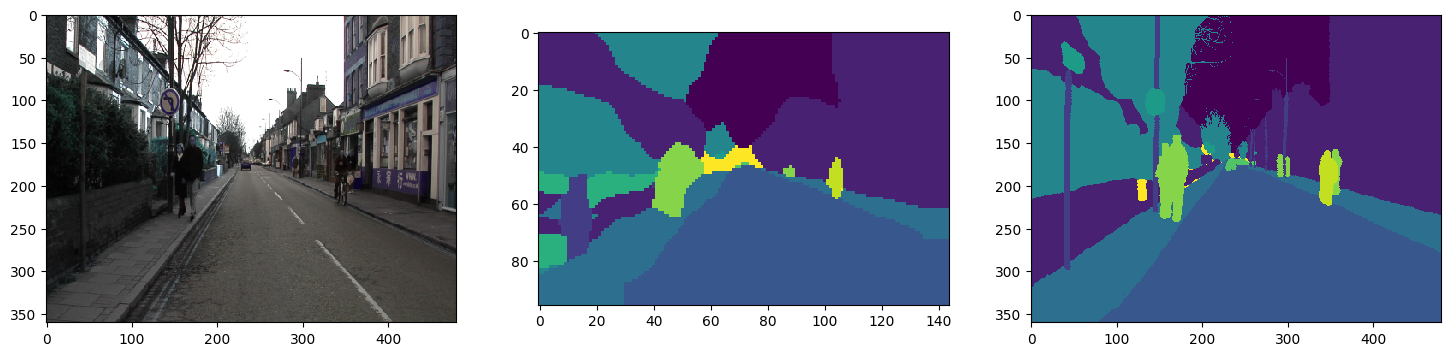

In [39]:
inp_fig_list = sorted(glob.glob(os.path.join(camvid_dir, 'test', '*.png')))
annot_fig_list = sorted(glob.glob(os.path.join(camvid_dir, 'testannot', '*.png')))

import time
t1 = time.time()

for i in range(100,110):
  inp_fig_idx = i
  inp_path = inp_fig_list[inp_fig_idx]
  out_path = "out.png"
  annot_path = annot_fig_list[inp_fig_idx]
  
  out = m.predict_segmentation(inp=inp_path, out_fname=out_path)
  
t2 = time.time()
print('prediction time = ',t2-t1)
  
  
inp_fig_idx = 100


inp_path = inp_fig_list[inp_fig_idx]
out_path = "out.png"
annot_path = annot_fig_list[inp_fig_idx]


out = m.predict_segmentation(inp=inp_path, out_fname=out_path)

plt.figure(figsize=(18,8), dpi=100)
plt.subplot(1,3, 1)
plt.imshow(cv2.imread(inp_path))
plt.subplot(1,3,2)
plt.imshow(out)
plt.subplot(1, 3, 3)
plt.imshow(cv2.imread(annot_path)[:, :, 0])
plt.savefig('predict_example{:d}.png'.format(inp_fig_idx))
plt.show()